### Load Module

In [1]:
import pandas as pd
import os
import json
import sys
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn


/opt/homebrew/Caskroom/miniforge/base/envs/vqa/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Box plotting using faster_rcnn

In [2]:
# model load

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = {
    "50" :fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device),
    # "60" :fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device),
    # "70" :fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device),
}


In [3]:
# data load
train_annotation_data = json.load(open(os.path.join('..', 'datasets', 'Annotations', 'v2_mscoco_train2014_annotations.json')))
train_annotation = pd.DataFrame(train_annotation_data["annotations"])
train_question_data = json.load(open(os.path.join('..', 'datasets', 'Questions', 'v2_OpenEnded_mscoco_train2014_questions.json')))
train_question = pd.DataFrame(train_question_data["questions"])

50


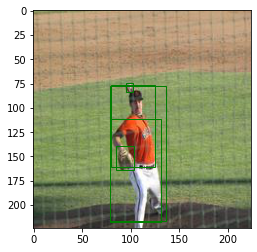

50


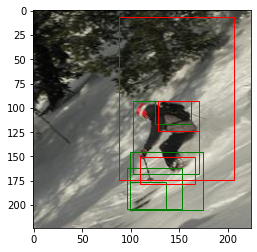

50


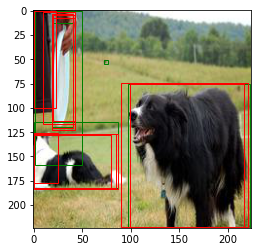

50


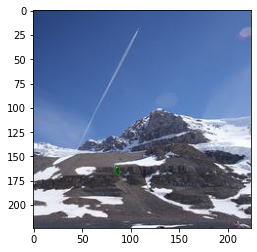

50


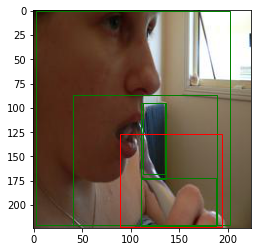

50


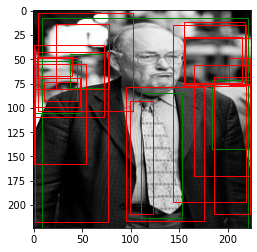

50


KeyboardInterrupt: 

In [17]:
# 해당 데이터에 대한 faster rcnn box visualization
# 기본 model 로드 코드
# self.model = fasterrcnn_resnet50_fpn(pretrained=True)
# self.model.roi_heads.nms_thresh=0.7

check = dict()
for idx in range(0, 1000):
    idx_answers = pd.DataFrame(train_annotation.loc[idx, 'answers'])
    quest = train_annotation.loc[idx, 'question_id']
    question = train_question[train_question['question_id']==quest]['question'][idx]
    image_id = train_question[train_question['question_id']==quest]['image_id'][idx]
    if image_id in check:
        continue
    check[image_id]=123

    normalize: transforms.Normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )

    image_rgb = Image.open(os.path.join('..','datasets','Images','train2014', f'COCO_train2014_{image_id:012}.jpg')).convert("RGB")

    transform_without_normalize = transforms.Compose([
        transforms.ToTensor(),
        #normalize,
    ])
    image_dict = {
        "without normalize": transform_without_normalize(image_rgb).unsqueeze(0).to(device)
    }
    for x in image_dict:
        for y in model:
            print(y)
            image = image_dict[x]
            result = model[y](image)
            fig,ax = plt.subplots(1)

            ax.imshow(image_rgb)
            for xx, obj in enumerate(result):
                # obj's scores is descending
                boxes = obj["boxes"]
                scores = obj["scores"]
                scth=0.2
                for bi, (box, score) in enumerate(zip(boxes, scores)):
                    x1, y1, x2, y2 = int(box[0].item()), int(box[1].item()), int(box[2].item()), int(box[3].item())
                    box_plot = Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green' if bi < 5 else 'red', linewidth=1)
                    ax.add_patch(box_plot)
            plt.show()


## Test code
### Explainability for Vision Transformers
#### 참고자료
* [https://hongl.tistory.com/234](https://hongl.tistory.com/234)
* [https://github.com/jacobgil/vit-explain](https://github.com/jacobgil/vit-explain)

In [4]:

def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [5]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


In [6]:
model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

Using cache found in /Users/ryuni/.cache/torch/hub/facebookresearch_deit_main


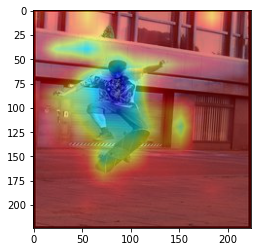

In [7]:
check = dict()
for idx in range(0, 1000):
    idx_answers = pd.DataFrame(train_annotation.loc[idx, 'answers'])
    quest = train_annotation.loc[idx, 'question_id']
    question = train_question[train_question['question_id']==quest]['question'][idx]
    image_id = train_question[train_question['question_id']==quest]['image_id'][idx]
    if image_id in check:
        continue
    check[image_id]=123

    img = Image.open(os.path.join('..','datasets','Images','train2014', f'COCO_train2014_{image_id:012}.jpg')).convert("RGB")

    img = img.resize((224, 224))
    input_tensor = transform(img).unsqueeze(0)

    head_fusion = "mean"
    discard_ratio =0.9

    attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
                        discard_ratio=discard_ratio)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)

    np_img = np.array(img)[:, :, ::-1]
    mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
    mask = show_mask_on_image(np_img, mask)

    #res_img = cv2.add(np_img, mask)
    #plt.imshow(res_img)
    plt.imshow(np_img)
    plt.imshow(mask)
    #cv2.imshow("Input Image", np_img)
    #cv2.imshow(name, mask)
    #cv2.imwrite("input.png", np_img)
    #cv2.imwrite(name, mask)
    #cv2.waitKey(-1)


## Attention Visualization of MCAoAN_vgg19 

In [8]:
# model에 들어가는 값이 model(img_feat, img_mask, qst)
# img_mask = True True .... True False False ... False가 들어가야 하고
# img_feat에 순서가 faster rcnn이 반환한 박스 순서랑 같음
# attention에 값과 faster rcnn에서 리턴된 box를 조인하여 그리기

#from model.MCAoAN_vgg19 import MCAoAN

os.path.dirname(os.path.abspath("__file__"))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from src.model.MCAoAN_vgg19 import ImagePreChannel

#model = ImagePreChannel().to(device)

